# ❄️ RT-03: Monitoreo de Cadena de Frío (LATAM, USD)

Análisis de series de temperatura en ruta, detección de excursiones y alertas operativas con impacto en USD.

---
id: "RT-03"
title: "Cold Chain Monitoring"
specialty: "Realtime / IoT"
process: "Deliver"
level: "Intermediate"
tags: ["cold-chain","temperature","iot","latam"]
estimated_time_min: 45
---

## 🔧 Instalación de Librerías

```bash
# Opción 1: Instalar librerías individuales
pip install pandas numpy matplotlib seaborn pyarrow

# Opción 2: Instalar todo el entorno del proyecto
pip install -e .[core,notebooks]
```

Librerías requeridas:
- `pandas`, `numpy` — datos/tiempo
- `matplotlib`, `seaborn` — visualización
- `pyarrow` — exportes Parquet

In [1]:
# Configurar entorno del repositorio
import sys
from pathlib import Path
_candidates = [Path.cwd(), *Path.cwd().parents]
_repo_root = None
for _p in _candidates:
    if (_p / 'pyproject.toml').exists() or (_p / 'src').exists():
        _repo_root = _p
        break
if _repo_root is None:
    _repo_root = Path.cwd()
if str(_repo_root) not in sys.path:
    sys.path.insert(0, str(_repo_root))
data_out = _repo_root / 'data' / 'processed' / 'rt03_cold_chain'
data_out.mkdir(parents=True, exist_ok=True)
print(f'✅ Entorno listo: {_repo_root}')
print(f'💾 Salida: {data_out}')

✅ Entorno listo: f:\GitHub\supply-chain-data-notebooks
💾 Salida: f:\GitHub\supply-chain-data-notebooks\data\processed\rt03_cold_chain


In [2]:
# Imports y validación rápida de librerías
import importlib
for lib in ["pandas","numpy","matplotlib","seaborn","pyarrow"]:
    m = importlib.import_module(lib)
    print(f'✅ {lib} versión: {getattr(m, "__version__", "ok")}')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
sns.set(style='whitegrid')

✅ pandas versión: 2.3.3
✅ numpy versión: 2.3.3
✅ matplotlib versión: 3.10.7
✅ seaborn versión: 0.13.2
✅ pyarrow versión: 21.0.0
✅ seaborn versión: 0.13.2
✅ pyarrow versión: 21.0.0


## 📋 Contexto de Negocio

- Productos refrigerados en LATAM (rutas urbanas/interurbanas).
- Rango objetivo de cadena de frío: 2–8 °C.
- Objetivos: detectar excursiones > X minutos fuera de rango; evaluar riesgo por lote; disparar alertas. 
- Cifras en USD para impacto económico (ej. costo de mermas).

### 🎲 Generación de datos sintéticos
- 50 viajes ("trips") con duración 4–8 horas @ 1 min de muestreo.
- Temperatura base 4.5 °C con ruido y eventos de excursión (puerta abierta, retrasos).
- Rutas y lotes simulados por viaje; temperatura ambiente (15–35 °C) como contexto.

In [3]:
# Generar series de temperatura sintéticas
np.random.seed(123)
n_trips = 50
trip_minutes = np.random.randint(240, 480, size=n_trips)  # 4–8 horas
start_date = pd.Timestamp('2025-08-01')
records = []
lot_counter = 1
for trip_id in range(1, n_trips+1):
    mins = trip_minutes[trip_id-1]
    ts = pd.date_range(start=start_date + pd.Timedelta(days=trip_id), periods=mins, freq='1min')
    ambient = np.random.uniform(15, 35)
    base = 4.5 + np.random.normal(0, 0.5, size=mins)
    # Inyectar 0–2 excursiones por viaje
    k_exc = np.random.randint(0, 3)
    temp = base.copy()
    for _ in range(k_exc):
        start_exc = np.random.randint(30, max(31, mins-30))
        dur = np.random.randint(8, 25)  # 8–24 min de excursión
        delta = np.random.uniform(2.5, 6.0) * np.random.choice([1,-1], p=[0.8,0.2])
        temp[start_exc:start_exc+dur] += delta
    lot_id = f'LOT-{lot_counter:04d}'
    lot_counter += 1
    route = np.random.choice(['LANE-NORTH','LANE-SOUTH','LANE-ANDES','LANE-COAST'])
    region = np.random.choice(['MEX','BRA','COL','PER','CHL','ARG'])
    df_trip = pd.DataFrame({
        'trip_id': trip_id,
        'route': route,
        'region': region,
        'lot_id': lot_id,
        'timestamp': ts,
        'temp_c': temp,
        'ambient_c': ambient
    })
    records.append(df_trip)
temp_df = pd.concat(records, ignore_index=True)
temp_df.head()

,trip_id,route,region,lot_id,timestamp,temp_c,ambient_c
0,1,LANE-COAST,ARG,LOT-0001,2025-08-02 00:00:00,4.870514,22.476029
1,1,LANE-COAST,ARG,LOT-0001,2025-08-02 00:01:00,4.855789,22.476029
2,1,LANE-COAST,ARG,LOT-0001,2025-08-02 00:02:00,4.649114,22.476029
3,1,LANE-COAST,ARG,LOT-0001,2025-08-02 00:03:00,4.732186,22.476029
4,1,LANE-COAST,ARG,LOT-0001,2025-08-02 00:04:00,4.559111,22.476029


#### 🧪 Fundamentos de los datos sintéticos
- Muestreo: 1 min para capturar excursiones cortas (8–24 min) típicas por aperturas/retardos.
- Distribuciones: `base≈4.5°C` con ruido gaussiano; `ambient_c∈[15,35]°C` para estrés térmico LATAM; 0–2 excursiones por viaje con deltas ±[2.5,6]°C.
- Eventos: inicio aleatorio y duración acotada; sesgo a sobrecalentamiento (prob=0.8) por exposición/puertas.
- Lotes/rutas/regiones: variables de contexto para análisis de riesgo operativo y trazabilidad en USD.
- Extensiones: perfiles por producto (vacunas/lácteos), sensores múltiples por unidad, y correlación con apertura de puerta/GPS.

### 🚨 Detección de excursiones
- Definición: `out_of_range = (temp_c < 2) or (temp_c > 8)`.
- Se agrupan periodos contiguos fuera de rango y se calcula su duración (minutos).
- Umbral de alerta: `threshold_min = 10` minutos fuera de rango en una misma excursión.

In [5]:
# Detectar excursiones y calcular duraciones
LOW, HIGH = 2.0, 8.0
threshold_min = 10
temp_df['out_of_range'] = (temp_df['temp_c'] < LOW) | (temp_df['temp_c'] > HIGH)
# Identificar cambios de estado por trip para segmentar
temp_df = temp_df.sort_values(['trip_id','timestamp'])
# Usar transform para comparar con el shift dentro de cada grupo
temp_df['state_change'] = (
    temp_df.groupby('trip_id')['out_of_range']
           .transform(lambda s: s.ne(s.shift(1)))
           .astype(int)
)
temp_df['segment_id'] = temp_df.groupby('trip_id')['state_change'].cumsum()
# Resumen por segmento fuera de rango
excursions = (
    temp_df[temp_df['out_of_range']]
      .groupby(['trip_id','route','region','lot_id','segment_id'])
      .agg(
          start=('timestamp','min'),
          end=('timestamp','max'),
          duration_min=('timestamp', lambda x: (x.max()-x.min()).total_seconds()/60 + 1),
          max_over=('temp_c', lambda s: max(0.0, s.max()-HIGH)),
          max_under=('temp_c', lambda s: max(0.0, LOW-s.min()))
      )
      .reset_index()
)
excursions['alert'] = excursions['duration_min'] >= threshold_min
# Exportar excursiones
excursions.to_parquet(data_out / 'excursions.parquet', index=False)
excursions.head()

,trip_id,route,region,lot_id,segment_id,start,end,duration_min,max_over,max_under,alert
0,1,LANE-COAST,ARG,LOT-0001,2,2025-08-02 02:29:00,2025-08-02 02:51:00,23.0,3.019661,0.000000,True
1,3,LANE-COAST,COL,LOT-0003,2,2025-08-04 01:36:00,2025-08-04 01:56:00,21.0,3.532667,0.000000,True
2,5,LANE-ANDES,BRA,LOT-0005,2,2025-08-06 00:44:00,2025-08-06 01:01:00,18.0,0.000000,1.861354,True
3,9,LANE-NORTH,PER,LOT-0009,2,2025-08-10 03:39:00,2025-08-10 03:57:00,19.0,2.460551,0.000000,True
4,10,LANE-SOUTH,PER,LOT-0010,2,2025-08-11 01:08:00,2025-08-11 01:21:00,14.0,0.000000,3.797494,True


#### 🧭 Detección y segmentación de excursiones
- Regla fuera de rango: `temp_c < 2` o `temp_c > 8` (productos refrigerados estándar).
- Segmentación: cortes cuando cambia `out_of_range` dentro de cada `trip_id`; agrega continuidad temporal.
- Duración: `max(ts) - min(ts) + 1 min` para incluir ambos extremos; robusto a muestreo regular.
- Severidad: `max_over` y `max_under` cuantifican cuánto se excede el rango; útiles para riesgo.
- Umbral `threshold_min=10`: práctico para reducir falsos positivos por picos breves; ajustar por SLA del producto.

### 📊 Riesgo por lote y alertas
- Riesgo como función del tiempo fuera de rango y severidad: `risk = 1 - exp(-a*min_out - b*sev)` (0–1).
- Clasificación: Low (<0.3), Medium (0.3–0.6), High (>0.6).
- Alertas: registrar excursiones con `alert=True` y lotes con riesgo Medium/High.

In [6]:
# Agregar métricas por lote
lot_summary = (
    excursions
      .groupby(['lot_id','trip_id','route','region'])
      .agg(
          total_exc_min=('duration_min','sum'),
          max_over=('max_over','max'),
          max_under=('max_under','max'),
          alerts=('alert','sum')
      )
      .reset_index()
)
# Severidad aprox = mayor delta sobre/under del rango
severity = lot_summary[['max_over','max_under']].max(axis=1)
a, b = 0.05, 0.4  # ponderaciones
lot_summary['risk_score'] = 1 - np.exp(-(a*lot_summary['total_exc_min'] + b*severity))

def risk_grade(x):
    if x > 0.6: return 'High'
    if x >= 0.3: return 'Medium'
    return 'Low'

lot_summary['risk_grade'] = lot_summary['risk_score'].apply(risk_grade)
# Alerts por excursión
alerts_df = excursions[excursions['alert']].copy()
# Exportes
lot_summary.to_parquet(data_out / 'risk_summary.parquet', index=False)
alerts_df.to_parquet(data_out / 'alerts.parquet', index=False)
print(f'✅ Exportados: excursions, risk_summary, alerts en {data_out}')

✅ Exportados: excursions, risk_summary, alerts en f:\GitHub\supply-chain-data-notebooks\data\processed\rt03_cold_chain


#### 📊 Modelo de riesgo y alertas
- Riesgo: `risk = 1 - exp(-(a·min_out + b·severity))` garantiza 0–1 y aumenta con tiempo/severidad.
- Ponderaciones (a,b): priorizan minutos vs severidad; calibrar con datos de merma/estudios de estabilidad.
- Grados: Low/Medium/High facilitan reglas operativas (rechazo, cuarentena, liberación condicionada).
- Alertas: `alert=True` cuando una excursión supera `threshold_min`; útil para monitoreo en tiempo real.
- USD: conectar `risk_score` con `E[merma_usd]` según valor del lote y penalizaciones regulatorias.

### 📈 Visualizaciones
- Serie temporal de muestra con excursiones resaltadas.
- Histograma de duración de excursiones.
- Barras de riesgo por ruta.

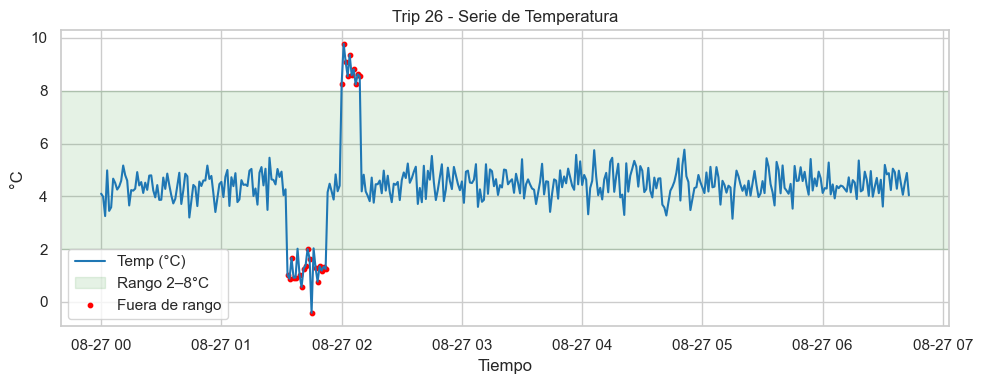

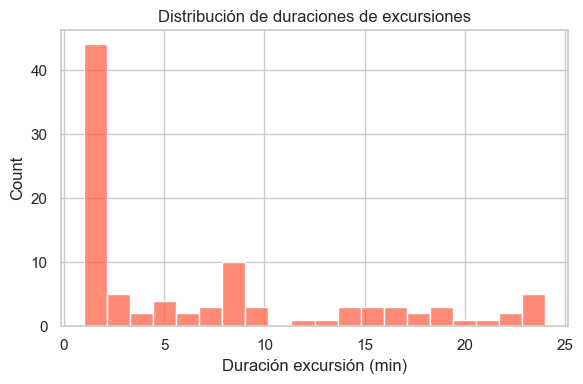

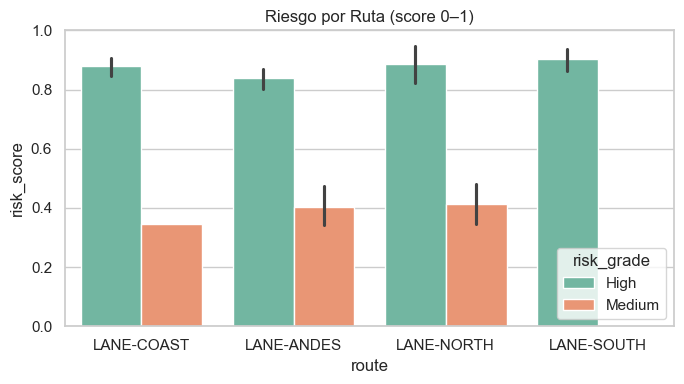

✅ Visuales exportadas a f:\GitHub\supply-chain-data-notebooks\data\processed\rt03_cold_chain


In [7]:
# Plot serie temporal de un viaje de muestra
sample_trip = int(temp_df['trip_id'].sample(1, random_state=42).iloc[0])
df_s = temp_df[temp_df['trip_id']==sample_trip].copy()
plt.figure(figsize=(10,4))
plt.plot(df_s['timestamp'], df_s['temp_c'], label='Temp (°C)', color='tab:blue')
plt.axhspan(LOW, HIGH, color='green', alpha=0.1, label='Rango 2–8°C')
plt.scatter(df_s.loc[df_s['out_of_range'],'timestamp'], df_s.loc[df_s['out_of_range'],'temp_c'], color='red', s=10, label='Fuera de rango')
plt.title(f'Trip {sample_trip} - Serie de Temperatura')
plt.xlabel('Tiempo')
plt.ylabel('°C')
plt.legend()
plt.tight_layout()
plt.savefig(data_out / 'sample_trip_timeseries.png', dpi=150)
plt.show()
# Histograma de duración de excursiones
plt.figure(figsize=(6,4))
sns.histplot(excursions['duration_min'], bins=20, color='tomato')
plt.xlabel('Duración excursión (min)')
plt.title('Distribución de duraciones de excursiones')
plt.tight_layout()
plt.savefig(data_out / 'excursion_duration_hist.png', dpi=150)
plt.show()
# Riesgo por ruta
plt.figure(figsize=(7,4))
sns.barplot(data=lot_summary, x='route', y='risk_score', hue='risk_grade', palette='Set2')
plt.title('Riesgo por Ruta (score 0–1)')
plt.ylim(0,1)
plt.tight_layout()
plt.savefig(data_out / 'risk_by_route.png', dpi=150)
plt.show()
print(f'✅ Visuales exportadas a {data_out}')

## ✅ Validación
- Archivos exportados existen.
- Rangos lógicos: temperatura [-10, 40], `risk_score` ∈ [0,1], duraciones ≥ 0.

In [8]:
# Validaciones finales
import os
expected = ['excursions.parquet','risk_summary.parquet','alerts.parquet','sample_trip_timeseries.png','excursion_duration_hist.png','risk_by_route.png']
for f in expected:
    assert (data_out / f).exists(), f'Missing: {f}'
    print(f'✅ {f} exists')
assert temp_df['temp_c'].between(-10, 40).all(), 'Temperatura fuera de rango plausible'
assert (excursions['duration_min']>=0).all(), 'Duración negativa'
assert lot_summary['risk_score'].between(0,1).all(), 'Risk fuera de [0,1]'
print('🎉 Notebook RT-03 ejecutado y validado')

✅ excursions.parquet exists
✅ risk_summary.parquet exists
✅ alerts.parquet exists
✅ sample_trip_timeseries.png exists
✅ excursion_duration_hist.png exists
✅ risk_by_route.png exists
🎉 Notebook RT-03 ejecutado y validado


## 📘 Explicaciones Técnicas y Supuestos
- Muestreo 1 min: permite detectar excursiones de 8–24 min típicas por aperturas/retardos.
- Segmentación: cambios en `out_of_range` por viaje; duración por `max(ts)-min(ts)+1`.
- Riesgo: función exponencial creciente en minutos fuera de rango y severidad (°C más allá del rango).
- LATAM: variación `ambient_c` (15–35 °C) y rutas (Andes/costa) justifican buffers y monitoreo continuo.
- Extensiones: SLA por producto, costo esperado de merma (USD), alertas en tiempo real (MQTT, webhooks).